## Sentiment Analysis using Recurrent Neural Network

In [ ]:
import os
import pandas as pd
import collections
import numpy as np
#Libraries for NLP
import re #for regex removal
import nltk
nltk.download('punkt') #for tokenization
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords #for removing stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
from nltk.stem.wordnet import WordNetLemmatizer #for lemmatization
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.tag import pos_tag
from functools import reduce #concatenate words into sentence using reduce
#Libraries for Transforming Data
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
#Libraries for word embeddings
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from tensorflow.keras.utils import pad_sequences #from keras_preprocessing.sequence import pad_sequences
#Libraries for neural network model
from keras.models import Sequential
from keras.layers import Dense, Embedding, SimpleRNN, LSTM, GRU, Bidirectional
#Libraries for callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\riddhi.pawar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\riddhi.pawar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\riddhi.pawar\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\riddhi.pawar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\riddhi.pawar\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
#Constants
EMBED_DIM = 100

### 1.Load Dataset Files  <a id="load_data">

In [ ]:
df1 = pd.read_csv("/content/US Airline Twitter Sentiment Analysis.csv", usecols=['text', 'airline_sentiment'])
print(f"df shape: {df.shape}")

df shape: (14640, 15)


In [ ]:
df1.head(5)

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [ ]:
df1['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

### 2.Data Wrangling <a id="preprocess_data">

#### 2.1. Preprocessing <a id='2.1'>

In [ ]:
#Customize stopwords list
for i in ["not", "no"]:
    stop_words.remove(i)
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

In [ ]:
def preprocess_doc(doc):
    #1. Removing URLS
    doc = re.sub('http\S+', '', doc).strip()
    doc = re.sub('www\S+', '', doc).strip()
    #2. Removing upper brackets to keep words like [user\'s]
    doc = doc.replace("\'", "")
    #3. Removing symbols and numbers
    doc = re.sub(r"[^a-zA-Z]+", ' ', doc).strip()

    #4. Convert string to tokens, lowercase it & remove stop words
    tokens = word_tokenize(doc)  #to convert a string to tokens
    tokens = tokens = [w.lower() for w in tokens if w.lower() not in stop_words and len(w)>1]

    #5. Remove airline names tokens
    airlines = ['virginamerica', 'united', 'southwestair', 'delta', 'usairways', 'americanair', 'jetblue'] #[re.sub(r" ", '', name.lower()) for name in airline_names]
    tokens = [word if word not in airlines else 'airline' for word in tokens]

    #6. Reducing repeated characters
    tokens = [re.sub(r"(.)\1{2,}", r"\1"*2, word) for word in tokens]

    #7. Convert word to its base form
    lemmatized_tokens = []
    for word, tag in pos_tag(tokens):
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_tokens.append(lemmatizer.lemmatize(word, pos))

    return lemmatized_tokens

In [ ]:
def preprocess_corpus(data):
    docs = [preprocess_doc(doc) for doc in data]
    return docs

In [ ]:
df1.text = df1.text.apply(preprocess_doc)

In [ ]:
df1.head()

,text,airline_sentiment
0,"[airline, dhepburn, say]",neutral
1,"[airline, plus, youve, added, commercial, expe...",positive
2,"[airline, didnt, today, must, mean, need, take...",neutral
3,"[airline, really, aggressive, blast, obnoxious...",negative
4,"[airline, really, big, bad, thing]",negative


In [ ]:
#Count total words in tweets
total_words = [word for doc in df1.text.values.tolist() for word in doc]
print(f"total words: {len(total_words)}, unique words: {len(set(total_words))}")

total words: 149754, unique words: 10244


In [ ]:
doc_len = [len(doc) for doc in df1.text.values.tolist()]
AVG_DOC_LEN = sum(doc_len)/len(doc_len)
MAX_DOC_LEN = max(doc_len)
print(f"avg. document length: {round(AVG_DOC_LEN,2)} \nmax. document length: {MAX_DOC_LEN} \nmin. document length: {min(doc_len)}")

avg. document length: 10.23 
max. document length: 22 
min. document length: 1


#### 2.2. Create word embedding using Gensim Word2Vec model

In [ ]:
tweets_data = df1.text.values.tolist()

In [ ]:
w2v_model = Word2Vec(sentences = tweets_data, vector_size = EMBED_DIM, window = 3, min_count = 2, workers = 4, sg = 1)

In [ ]:
 w2v_model.wv['airline']

array([-0.00248996,  0.2013816 ,  0.1004726 ,  0.05333913, -0.12598242,
       -0.41469687,  0.5575385 ,  0.31655812, -0.34848347, -0.15657872,
        0.16154552, -0.2807999 ,  0.02906113,  0.03103315,  0.04903178,
        0.0074309 ,  0.3473239 , -0.16165884, -0.30593127, -0.52660125,
        0.24722753,  0.21984391,  0.33874264, -0.16237764,  0.02405616,
        0.02069281,  0.03314316, -0.14770836, -0.20141426,  0.03513547,
       -0.05112888,  0.13137235, -0.06221941, -0.09736588,  0.0643849 ,
        0.03532197,  0.13301378, -0.44487047, -0.15856378, -0.40339583,
        0.03784901, -0.20311233, -0.17844477,  0.25112063,  0.16813771,
        0.09553143, -0.36390188,  0.12543967, -0.01658973,  0.2376483 ,
        0.07508784, -0.13007823, -0.05448068,  0.25510427,  0.13668099,
       -0.11720008, -0.06147424, -0.18892637, -0.25023615,  0.11584996,
       -0.05718264,  0.10231317, -0.17416035, -0.24200068, -0.15732941,
        0.27790338,  0.06247644,  0.01754765, -0.13150115, -0.06

In [ ]:
# list of vocab words
print(w2v_model.wv.index_to_key[:10])

['airline', 'flight', 'get', 'not', 'no', 'hour', 'thanks', 'service', 'cancel', 'time']


In [ ]:
w2v_model.wv.most_similar('service')

[('relation', 0.8694310188293457),
 ('poor', 0.827164351940155),
 ('treat', 0.8201369047164917),
 ('loyal', 0.8016438484191895),
 ('svc', 0.8002258539199829),
 ('terrible', 0.7969107627868652),
 ('horrible', 0.7853723168373108),
 ('lack', 0.7832363247871399),
 ('worst', 0.7802977561950684),
 ('job', 0.7691777944564819)]

In [ ]:
w2v_model.wv.most_similar('thank')

[('appreciate', 0.9530863165855408),
 ('thanks', 0.9482395648956299),
 ('quick', 0.9332591891288757),
 ('ok', 0.9214147329330444),
 ('yes', 0.9134311676025391),
 ('much', 0.9114036560058594),
 ('reply', 0.9101050496101379),
 ('tweet', 0.8990885615348816),
 ('awesome', 0.8990606069564819),
 ('respond', 0.8883876800537109)]

#### 2.3. Storing embeddings as word vectors

In [ ]:
# Store just the words + their trained embeddings.
'''word_vectors = w2v_model.wv
word_vectors.save("tweets_word2vec_embeddings.wordvectors")
# Load back with memory-mapping, read-only {str => 1D numpy array}
word_embeddings = KeyedVectors.load("tweets_word2vec_embeddings.wordvectors", mmap='r')'''

In [ ]:
#word_embeddings['airline']

array([ 0.02656677,  0.28612143,  0.11267237,  0.05750958, -0.13075496,
       -0.43463072,  0.3565043 ,  0.5801022 , -0.46001562, -0.16465746,
        0.32374367, -0.51076883, -0.07438786,  0.20830254, -0.08944345,
       -0.2368878 ,  0.05530449, -0.2392324 , -0.22642162, -0.42673153,
        0.40420145, -0.08497433,  0.209023  , -0.08802194,  0.09763402,
       -0.09872195,  0.06651339, -0.11707778, -0.06152895,  0.0173998 ,
        0.0056053 ,  0.23111828,  0.12283489, -0.28764006,  0.09376011,
        0.23641618,  0.20897202, -0.19999863, -0.04102065, -0.5754812 ,
       -0.10188477, -0.27816257, -0.01712024,  0.14195485,  0.1390595 ,
       -0.15669267, -0.38107497,  0.16710803,  0.01243436,  0.29127383,
       -0.01309904, -0.11292884,  0.02853567, -0.05693087,  0.21703784,
       -0.01150485,  0.04555632,  0.04500404, -0.1740667 ,  0.25229317,
       -0.08337998,  0.02525779,  0.05501266, -0.1996165 , -0.3377214 ,
        0.09769087,  0.3076257 ,  0.3236968 , -0.33734342,  0.12

In [ ]:
#print(len(word_embeddings))

4858


#### 2.3. Storing embeddings  as text file <a id='2.3'>

In [ ]:
#Store word embeddings
w2v_model.wv.save_word2vec_format('twitter_data_embedding_word2vec_old.txt' ,binary=False)

#### 2.4. Load word Embeddings <a id='2.4'>

In [ ]:
#Load words and embeddings
embeddings_dict = {}
f = open(os.path.join(os.getcwd(), 'twitter_data_embedding_word2vec_old.txt'),encoding='utf-8')
for line in f:
    values = line.split()
    if(len(values)==2): #To skip first value
        continue
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_dict[word] = coefs
f.close()
print(f'loaded {len(embeddings_dict)} word vectors')

loaded 4858 word vectors


In [ ]:
embeddings_dict['airline']

array(['0.026566766', '0.28612143', '0.112672366', '0.057509582',
       '-0.13075496', '-0.43463072', '0.3565043', '0.5801022',
       '-0.46001562', '-0.16465746', '0.32374367', '-0.51076883',
       '-0.07438786', '0.20830254', '-0.08944345', '-0.2368878',
       '0.055304486', '-0.2392324', '-0.22642162', '-0.42673153',
       '0.40420145', '-0.084974326', '0.209023', '-0.08802194',
       '0.097634025', '-0.09872195', '0.06651339', '-0.11707778',
       '-0.061528955', '0.017399795', '0.0056053023', '0.23111828',
       '0.12283489', '-0.28764006', '0.09376011', '0.23641618',
       '0.20897202', '-0.19999863', '-0.041020654', '-0.5754812',
       '-0.10188477', '-0.27816257', '-0.017120244', '0.14195485',
       '0.1390595', '-0.15669267', '-0.38107497', '0.16710803',
       '0.012434363', '0.29127383', '-0.013099045', '-0.112928845',
       '0.028535668', '-0.056930874', '0.21703784', '-0.0115048485',
       '0.045556318', '0.045004036', '-0.1740667', '0.25229317',
       '-0.08

In [ ]:
print(len(embeddings_dict['airline']))

100


#### 2.5. Create embedding matrix and padded sequences <a id='2.5'>

In [ ]:
#Convert Tweets into Sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets_data)
tweets_sequences = tokenizer.texts_to_sequences(tweets_data)
#Pads sequences to the same length
tweets_sequences = pad_sequences(tweets_sequences, maxlen = MAX_DOC_LEN, padding = 'post')
unique_words_indexes = tokenizer.word_index
print(f"tweet: {tweets_data[1]} \nsequence: {tweets_sequences[1]}")
print(f'unique tokens/words: {len(unique_words_indexes)} \nsequences/documents: {len(tweets_sequences)} i.e. no of tweets')

tweet: ['airline', 'plus', 'youve', 'added', 'commercial', 'experience', 'tacky'] 
sequence: [   1  408  412 1934 1009  104 4860    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
unique tokens/words: 10244 
sequences/documents: 14640 i.e. no of tweets


In [ ]:
#Create embedding matrix
VOCAB_WORD_COUNT = len(unique_words_indexes) + 1
embedding_matrix = np.zeros((VOCAB_WORD_COUNT, EMBED_DIM))
#Matrix of all unique words embeddings
for word, i in unique_words_indexes.items():
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
print(f"embedding matrix shape before: {embedding_matrix.shape}")

embedding matrix shape before: (10245, 100)


#### 2.6. Train Test Split <a id='2.6'>

In [ ]:
def get_sentiment_distribution(data):
    pos_count = len([1 for val in data if val == 'positive'])
    neg_count = len([1 for val in data if val == 'negative'])
    neutral_count = len([1 for val in data if val == 'neutral'])
    print(f"positive = {pos_count}, negative = {neg_count}, neutral = {neutral_count}")

In [ ]:
# Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(tweets_sequences, df1['airline_sentiment'], test_size=0.30, shuffle=True, random_state=1, stratify=df1['airline_sentiment'])
print(f"train data: {len(y_train)}")
get_sentiment_distribution(y_train)
print(f"test data: {len(y_test)}")
get_sentiment_distribution(y_test)

train data: 10248
positive = 1654, negative = 6425, neutral = 2169
test data: 4392
positive = 709, negative = 2753, neutral = 930


#### 2.7. Converting the target classes to numbers <a id='2.7'>

In [ ]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

print('"{}" is converted into {}'.format(y_train[0], y_train_le[0]))
print('"{}" is converted into {}'.format(y_train_le[0], y_train_oh[0]))

"neutral" is converted into 0
"0" is converted into [1. 0. 0.]


In [ ]:
y_train_oh[:5]

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

### 3.Model Train

In [ ]:
VOCAB_WORD_COUNT = 10245
EMBED_DIM = 100
MAX_DOC_LEN = 22

In [ ]:
#Embedding layer
embedding_layer = Embedding(input_dim = VOCAB_WORD_COUNT,
                            output_dim = EMBED_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_DOC_LEN, trainable=False)

#### 3.1. SimpleRNN Model

In [ ]:
#Model-1
rnn_model = Sequential(name = 'simple_rnn_model_1')
rnn_model.add(embedding_layer)
rnn_model.add(SimpleRNN(units = 32, name = 'layer_1')) #activation="tanh"
#rnn_model.add(SimpleRNN(units = 128, name = 'layer_1')) #activation="tanh"
rnn_model.add(Dense(units = 3, activation = 'softmax', name = 'output_layer')) #o/p probability of 3 classes
rnn_model.summary()

Model: "simple_rnn_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 22, 100)           1024500   
                                                                 
 layer_1 (SimpleRNN)         (None, 32)                4256      
                                                                 
 output_layer (Dense)        (None, 3)                 99        
                                                                 
Total params: 1,028,855
Trainable params: 4,355
Non-trainable params: 1,024,500
_________________________________________________________________


In [ ]:
#Model-2
rnn_model2 = Sequential(name = 'simple_rnn_model_2')
rnn_model2.add(embedding_layer)
rnn_model2.add(SimpleRNN(units = 128, name = 'layer_1')) #activation="tanh"
rnn_model2.add(Dense(units = 10, activation = 'relu', name = 'layer_2'))
rnn_model2.add(Dense(units = 3, activation = 'softmax', name = 'output_layer')) #o/p probability of 3 classes
rnn_model2.summary()

Model: "simple_rnn_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 22, 100)           1024500   
                                                                 
 layer_1 (SimpleRNN)         (None, 128)               29312     
                                                                 
 layer_2 (Dense)             (None, 10)                1290      
                                                                 
 output_layer (Dense)        (None, 3)                 33        
                                                                 
Total params: 1,055,135
Trainable params: 30,635
Non-trainable params: 1,024,500
_________________________________________________________________


#### 3.2. LSTM Model

In [ ]:
#Model-3
lstm_model = Sequential(name = 'lstm_model_1')
lstm_model.add(embedding_layer)
lstm_model.add(LSTM(units = 128, name = 'layer_1')) #activation="tanh", recurrent_activation="sigmoid"
lstm_model.add(Dense(units = 3, activation = 'softmax', name = 'output_layer')) #o/p probability of 3 classes
lstm_model.summary()

Model: "lstm_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 22, 100)           1024500   
                                                                 
 layer_1 (LSTM)              (None, 128)               117248    
                                                                 
 output_layer (Dense)        (None, 3)                 387       
                                                                 
Total params: 1,142,135
Trainable params: 117,635
Non-trainable params: 1,024,500
_________________________________________________________________


#### 3.2. GRU Model

In [ ]:
#Model-4
gru_model = Sequential(name = 'gru_model_1')
gru_model.add(embedding_layer)
gru_model.add(GRU(units = 128, name = 'layer_1')) #activation="tanh", recurrent_activation="sigmoid"
gru_model.add(Dense(units = 3, activation = 'softmax', name = 'output_layer')) #o/p probability of 3 classes
gru_model.summary()

Model: "gru_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 22, 100)           1024500   
                                                                 
 layer_1 (GRU)               (None, 128)               88320     
                                                                 
 output_layer (Dense)        (None, 3)                 387       
                                                                 
Total params: 1,113,207
Trainable params: 88,707
Non-trainable params: 1,024,500
_________________________________________________________________


#### 3.3. Bidirectional LSTM Model

In [ ]:
#Model-5
bidirectional_lstm_model = Sequential(name = 'bidirectional_lstm_model_1')
bidirectional_lstm_model.add(embedding_layer)
bidirectional_lstm_model.add(Bidirectional(LSTM(units = 64))) #activation="tanh", recurrent_activation="sigmoid"
bidirectional_lstm_model.add(Dense(units = 3, activation = 'softmax', name = 'output_layer')) #o/p probability of 3 classes
bidirectional_lstm_model.summary()

Model: "bidirectional_lstm_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 22, 100)           1024500   
                                                                 
 bidirectional_6 (Bidirectio  (None, 128)              84480     
 nal)                                                            
                                                                 
 output_layer (Dense)        (None, 3)                 387       
                                                                 
Total params: 1,109,367
Trainable params: 84,867
Non-trainable params: 1,024,500
_________________________________________________________________


In [ ]:
def train_test(model_id, model, optimizer, loss, performance_metrics, callbacks, x_train, y_train, x_valid, y_valid, x_test, y_test, epochs, batch_size):
    model.compile(optimizer=optimizer, loss=loss, metrics=performance_metrics)
    #_________Training__________callbacks
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(x_valid, y_valid),
                        callbacks=callbacks)
    #__________Testing____________
    # returns metrics values (passed in model.compile) on test dataset
    test_metrics = model.evaluate(x_test, y_test, batch_size)
    return test_metrics

### 4.Hyperparameter Tuning


##### Notes
- learning rate can be 0.1, 0.01, 0.001, 0.0001, 0.00001
- Minibatch sizes that are commonly used are 32, 64, 128, 256
- No of Layers, 3 layer net outperforms the 2 layer net but going beyond that rarely helps the network.

In [ ]:
#Use test data for validation as well initially
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.CategoricalCrossentropy()
performance_metrics = ['accuracy','AUC','Recall','Precision']
epochs = 50
batch_size = 32
log_path = './rnn_model_logs/simple_rnn/adam_unit32' #dense2_adam_epoch50
tb_callback = keras.callbacks.TensorBoard(log_dir=log_path, histogram_freq=0)
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='min')
callbacks = [tb_callback, earlyStopping, reduce_lr_loss]

In [ ]:
test_metrics = train_test(rnn_model.name, rnn_model, optimizer, loss,
           performance_metrics, callbacks,
           x_train, y_train_oh, x_test, y_test_oh, x_test, y_test_oh,
           epochs, batch_size)

Epoch 1/50
321/321 [==============================] - 6s 12ms/step - loss: 0.8716 - accuracy: 0.6221 - auc: 0.7899 - recall: 0.4946 - precision: 0.7142 - val_loss: 0.7840 - val_accuracy: 0.6635 - val_auc: 0.8349 - val_recall: 0.6157 - val_precision: 0.7197 - lr: 1.0000e-04
Epoch 2/50
321/321 [==============================] - 3s 9ms/step - loss: 0.7739 - accuracy: 0.6648 - auc: 0.8380 - recall: 0.5926 - precision: 0.7359 - val_loss: 0.7728 - val_accuracy: 0.6753 - val_auc: 0.8412 - val_recall: 0.6243 - val_precision: 0.7137 - lr: 1.0000e-04
Epoch 3/50
321/321 [==============================] - 3s 8ms/step - loss: 0.7558 - accuracy: 0.6768 - auc: 0.8450 - recall: 0.5830 - precision: 0.7537 - val_loss: 0.7421 - val_accuracy: 0.6817 - val_auc: 0.8511 - val_recall: 0.5827 - val_precision: 0.7630 - lr: 1.0000e-04
Epoch 4/50
321/321 [==============================] - 3s 10ms/step - loss: 0.7443 - accuracy: 0.6810 - auc: 0.8495 - recall: 0.5773 - precision: 0.7625 - val_loss: 0.7356 - val_acc

319/321 [============================>.] - ETA: 0s - loss: 0.6683 - accuracy: 0.7196 - auc: 0.8807 - recall: 0.6043 - precision: 0.8084
Epoch 30: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
321/321 [==============================] - 3s 10ms/step - loss: 0.6680 - accuracy: 0.7198 - auc: 0.8808 - recall: 0.6044 - precision: 0.8087 - val_loss: 0.6683 - val_accuracy: 0.7143 - val_auc: 0.8799 - val_recall: 0.6109 - val_precision: 0.7992 - lr: 1.0000e-05
Epoch 31/50
321/321 [==============================] - 3s 10ms/step - loss: 0.6676 - accuracy: 0.7186 - auc: 0.8808 - recall: 0.6081 - precision: 0.8066 - val_loss: 0.6675 - val_accuracy: 0.7170 - val_auc: 0.8803 - val_recall: 0.6079 - val_precision: 0.8040 - lr: 1.0000e-06
Epoch 32/50
315/321 [============================>.] - ETA: 0s - loss: 0.6682 - accuracy: 0.7211 - auc: 0.8807 - recall: 0.6034 - precision: 0.8090
Epoch 32: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
321/321 [===============

In [ ]:
test_metrics

[0.6675219535827637,
 0.7169854044914246,
 0.8802732229232788,
 0.6079235076904297,
 0.8039746880531311]

### 5.Performance Evaluation (using Tensorboard)

#### 5.1.RNN Models Validation Accuracy using diff. optimizers

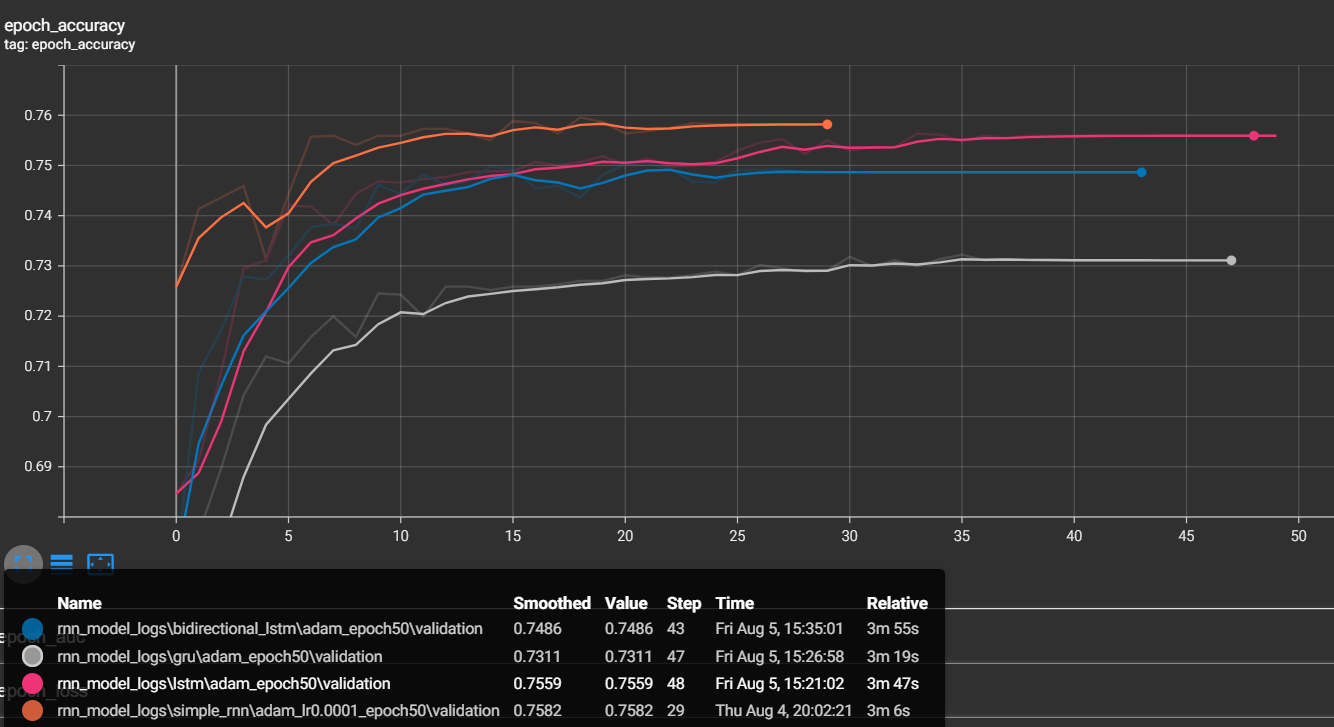

#### 5.2.RNN Models Validation Loss using diff. optimizers

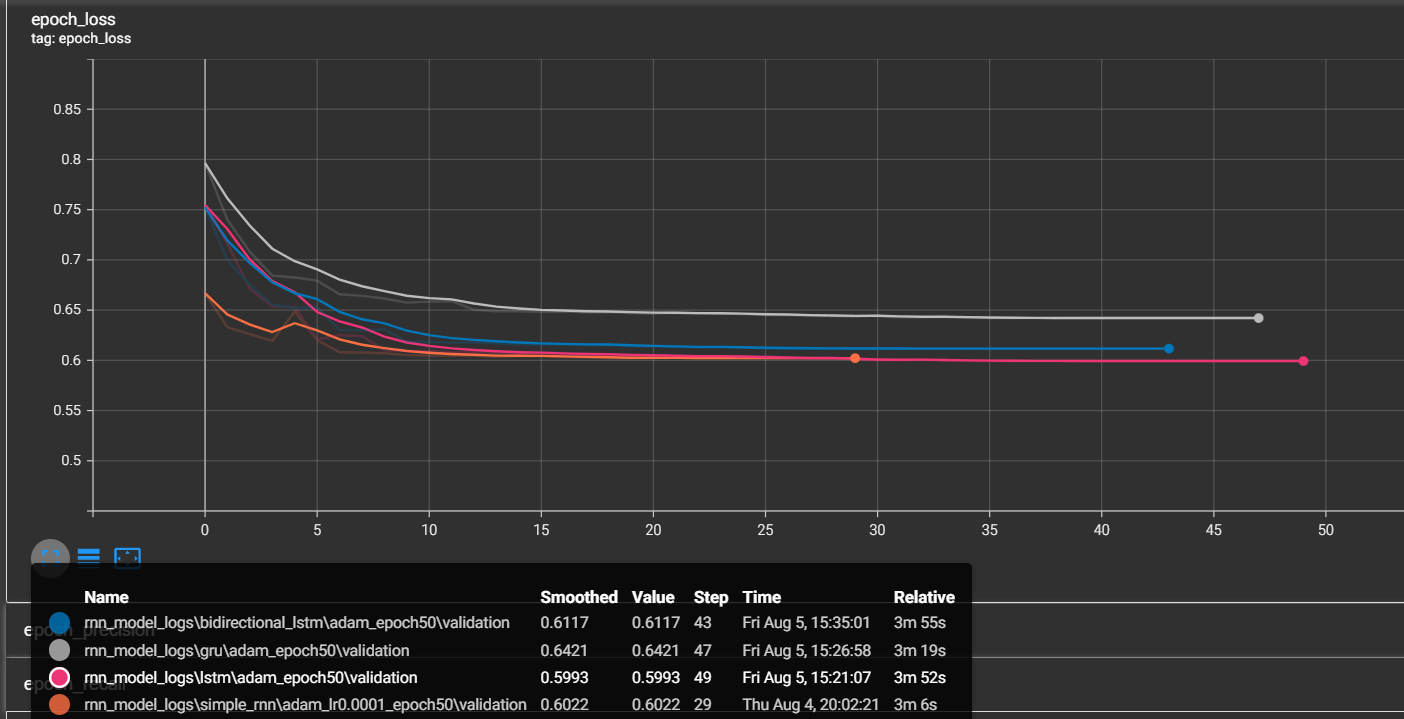

### Best model: simpleRNN with 128 hidden neurons